# Clinical NLP to predict readmission with discharge summaries<span class="tocSkip"></span></h1>

In [1]:
import pandas as pd
import numpy as np
# For interacting with PostgreSQL database for mimic queries
import psycopg2

# Ploting functions
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

plotly.tools.set_credentials_file(username='mlpaff', api_key='lYV8hhGxZlP988tplymj')
plotly.tools.set_config_file(world_readable=True,
                             sharing='public')

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(20, 10)
plt.style.use(['dark_background'])

from sklearn.model_selection import train_test_split 

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter

color_set = ['#A9CA59', '#6582C4', '#62C9BC', '#F58D50', '#2AD7F4',
             '#AB3EED', '#FF6CB2', '#FFA466', '#FFE256', '#47EAAC', '#2AD7F4', '#3C8CF9']

# specify user and database for SQL queries
sqluser = 'mattmimic'
dbname = 'mimic'
set_schema = '--search_path=mimiciii'

# Connect to the database
# con = psycopg2.connect(dbname = dbname, user = sqluser, options = set_schema)

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Admissions-table" data-toc-modified-id="Admissions-table-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Admissions table</a></span></li><li><span><a href="#NOTEEVENTS-table" data-toc-modified-id="NOTEEVENTS-table-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NOTEEVENTS table</a></span></li><li><span><a href="#Load-in-Andrew's-processed-admissions-table-for-merging-with-notes" data-toc-modified-id="Load-in-Andrew's-processed-admissions-table-for-merging-with-notes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load in Andrew's processed admissions table for merging with notes</a></span><ul class="toc-item"><li><span><a href="#Merge-notes-with-admissions-table" data-toc-modified-id="Merge-notes-with-admissions-table-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Merge notes with admissions table</a></span></li></ul></li><li><span><a href="#Create-training-and-test-dataframes" data-toc-modified-id="Create-training-and-test-dataframes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create training and test dataframes</a></span></li><li><span><a href="#Preprocess-text-data" data-toc-modified-id="Preprocess-text-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Preprocess text data</a></span><ul class="toc-item"><li><span><a href="#Data-balancing-applied-using-SMOTE" data-toc-modified-id="Data-balancing-applied-using-SMOTE-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Data balancing applied using SMOTE</a></span></li></ul></li><li><span><a href="#Build-a-tokenizer" data-toc-modified-id="Build-a-tokenizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build a tokenizer</a></span><ul class="toc-item"><li><span><a href="#Customize-tokenizer-(BOW-model)" data-toc-modified-id="Customize-tokenizer-(BOW-model)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Customize tokenizer (BOW model)</a></span></li></ul></li><li><span><a href="#Build-a-simple-vectorizer-(BOW)" data-toc-modified-id="Build-a-simple-vectorizer-(BOW)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Build a simple vectorizer (BOW)</a></span><ul class="toc-item"><li><span><a href="#Build-a-vectorizer-on-clinical-notes" data-toc-modified-id="Build-a-vectorizer-on-clinical-notes-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Build a vectorizer on clinical notes</a></span></li></ul></li><li><span><a href="#Build-simple-predictive-model" data-toc-modified-id="Build-simple-predictive-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Build simple predictive model</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model evaluation</a></span></li><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Word2Vec</a></span><ul class="toc-item"><li><span><a href="#W2V-preprocessing-of-text" data-toc-modified-id="W2V-preprocessing-of-text-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>W2V preprocessing of text</a></span><ul class="toc-item"><li><span><a href="#Word-2-Vec-implementation" data-toc-modified-id="Word-2-Vec-implementation-10.1.1"><span class="toc-item-num">10.1.1&nbsp;&nbsp;</span>Word 2 Vec implementation</a></span></li></ul></li></ul></li><li><span><a href="#Train-a-simple-model" data-toc-modified-id="Train-a-simple-model-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Train a simple model</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Model evaluation</a></span></li><li><span><a href="#SMOTE-balancing" data-toc-modified-id="SMOTE-balancing-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>SMOTE balancing</a></span></li><li><span><a href="#Train-a-decision-tree-on-vectorized-notes" data-toc-modified-id="Train-a-decision-tree-on-vectorized-notes-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Train a decision tree on vectorized notes</a></span></li><li><span><a href="#Train-a-logistic-regression-model" data-toc-modified-id="Train-a-logistic-regression-model-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Train a logistic regression model</a></span></li></ul></div>

# Admissions table

In [2]:
con = psycopg2.connect(dbname = dbname, user = sqluser, options = set_schema)
query = 'SELECT subject_id, hadm_id, admittime, dischtime, deathtime, admission_type, hospital_expire_flag FROM admissions;'
admissions = pd.read_sql_query(query, con, parse_dates=['admittime', 'dischtime', 'deathtime'])
con.close()

# we will drop all patients that had negative

admissions.sort_values(['subject_id', 'admittime'], inplace=True)

# Create a column for next admission time (if it exists)
admissions['next_admittime'] = admissions.groupby('subject_id')['admittime'].shift(-1)
# Get the next admission type
admissions['next_admit_type'] = admissions.groupby('subject_id')['admission_type'].shift(-1)

admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,hospital_expire_flag,next_admittime,next_admit_type
212,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,0,NaT,NaN
213,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,0,NaT,NaN
214,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,0,NaT,NaN
215,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,0,NaT,NaN
216,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,0,NaT,NaN


In [3]:
# Filter out elective emissions since we are interested in uplanned re-admissions
rows = admissions['next_admit_type'] == 'ELECTIVE'
admissions.loc[rows, 'next_admittime'] = pd.NaT
admissions.loc[rows, 'next_admit_type'] = np.NaN

# Sort by subject_id and admission date
admissions.sort_values(['subject_id', 'admittime'])

# back fill
admissions[['next_admittime', 'next_admit_type']] = admissions.groupby('subject_id')[['next_admittime', 'next_admit_type']].fillna(method='bfill')
# Calculate the days until the next admission
admissions['days_next_admit'] = (admissions.next_admittime - admissions.dischtime).dt.total_seconds() / (24*60*60)

# Filter out the hospital admissions where the patient died. We know that rows will not have a "next admission" and wont add any useful information for predicting readmission rates
admissions = admissions[admissions['hospital_expire_flag'] != 1]

admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,hospital_expire_flag,next_admittime,next_admit_type,days_next_admit
212,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,0,NaT,NaN,NaN
213,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,0,NaT,NaN,NaN
214,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,0,NaT,NaN,NaN
215,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,0,NaT,NaN,NaN
216,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,0,NaT,NaN,NaN


In [ ]:
# # hist_data = [admissions.days_next_admit.dropna()]
# # fig = ff.create_distplot(hist_data, group_labels=['Days between Admissions'], show_rug=False, bin_size=100)

# trace = go.Histogram(
#     x = admissions['days_next_admit']
# )
# layout = go.Layout(
#     xaxis = dict(
#         title = 'Days between Admissions'
#     ),
#     yaxis = dict(
#         title = 'Count'
#     )
# )

# fig = go.Figure(data = [trace], layout = layout)

# iplot(fig)

# NOTEEVENTS table

In [4]:
# %%time
con = psycopg2.connect(dbname = dbname, user = sqluser, options = set_schema)
query = 'SELECT * FROM noteevents;'
notes = pd.read_sql_query(query, con)
con.close()
notes.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
0,174,22532,167853.0,2151-08-04,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2162-3-3**] D...


In [7]:
# Filter to discharge summary notes only
dis_notes = notes[notes['category'] == 'Discharge summary'].copy()

In [8]:
assert dis_notes.duplicated(['hadm_id']).sum() == 0, 'Multiple discharge summaries per admission'

AssertionError: Multiple discharge summaries per admission

In [9]:
# Grab just the last discharge summaries by hadm_id
last_dis_notes = dis_notes.groupby(['subject_id', 'hadm_id']).nth(-1).reset_index()
assert last_dis_notes.duplicated(['hadm_id']).sum() == 0, 'Multiple discharge summaries per admission'

# Load in Andrew's processed admissions table for merging with notes

In [20]:
adm_processed = pd.read_csv('../admission_processed.csv', parse_dates=['admittime', 'dischtime', 'deathtime', 'next_admittime'], date_parser=pd.to_datetime)
adm_processed.dtypes

row_id                           int64
subject_id                       int64
hadm_id                          int64
admittime               datetime64[ns]
dischtime               datetime64[ns]
deathtime               datetime64[ns]
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
ethnicity                       object
edregtime                       object
edouttime                       object
diagnosis                       object
hospital_expire_flag             int64
has_chartevents_data             int64
total_prior_admits               int64
next_admittime          datetime64[ns]
next_admit_type                 object
days_next_admit                float64
num_medications                  int64
num_lab_tests                  float64
perc_tests_abnormal      

In [23]:
last_dis_notes.shape

(52726, 11)

## Merge notes with admissions table

In [25]:
#adm_notes = admissions.merge(last_dis_notes, on = ['subject_id', 'hadm_id'], how = 'left')

# Merge notes table with Andrew's processed table
adm_notes = adm_processed.merge(last_dis_notes, on = ['subject_id', 'hadm_id'], how = 'left')

# assert len(admissions) == len(adm_notes), 'Number of rows increased'

# Remove Newborn admissions
adm_notes = adm_notes[adm_notes['admission_type'] != 'NEWBORN']

# Generate output label for readmissions under 30 days
adm_notes['output_label'] = (adm_notes['days_next_admit'] < 30).astype('int')

row_id_x                         int64
subject_id                       int64
hadm_id                          int64
admittime               datetime64[ns]
dischtime               datetime64[ns]
deathtime               datetime64[ns]
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
ethnicity                       object
edregtime                       object
edouttime                       object
diagnosis                       object
hospital_expire_flag             int64
has_chartevents_data             int64
total_prior_admits               int64
next_admittime          datetime64[ns]
next_admit_type                 object
days_next_admit                float64
num_medications                  int64
num_lab_tests                  float64
perc_tests_abnormal      

In [28]:
adm_notes.text.isnull().sum() / len(adm_notes)

0.023156774021825925

In [29]:
list(adm_notes.admission_type.unique())

['EMERGENCY', 'ELECTIVE', 'URGENT']

In [30]:
adm_notes.shape

(41327, 41)

In [31]:
print('number of patients that were re-admitted within 30 days:', len(adm_notes[adm_notes['output_label'] == 1]))
print('fraction of patients re-admitted within 30 days:', len(adm_notes[adm_notes['output_label'] == 1]) / len(adm_notes))

number of patients that were re-admitted within 30 days: 2779
fraction of patients re-admitted within 30 days: 0.0672441745106105


(45321, 20)

# Create training and test dataframes

In [32]:
# Split data into train, validation and test sets

# shuffle the samples
adm_notes = adm_notes.sample(n = len(adm_notes), random_state=42)
adm_notes.reset_index(drop=True, inplace=True)

In [34]:
target = adm_notes[['output_label']]
data = adm_notes[['subject_id', 'hadm_id', 'text']]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state = 0)

# Preprocess text data

In [38]:
def preprocess_text(df):
    ''' Preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    '''
    
    df['text'] = df['text'].fillna(' ')
    df['text'] = df['text'].str.replace('\n', ' ')
    df['text'] = df['text'].str.replace('\r', ' ')
    return df

In [40]:
X_test, X_train = preprocess_text(X_test), preprocess_text(X_train)

,subject_id,hadm_id,text
27144,7363,168193,"Name: [**Known lastname 3567**],[**Known firs..."
26759,9906,175051,Admission Date: [**2103-2-7**] D...
3656,23739,157370,Admission Date: [**2127-5-7**] D...
322,591,154785,Admission Date: [**2161-12-1**] ...
21686,77034,176891,Admission Date: [**2150-11-9**] ...


## Data balancing applied using SMOTE

# Build a tokenizer

In [42]:
import nltk
from nltk import word_tokenize
# nltk.download()

In [43]:
word_tokenize('This should be tokenized. 11/14/2018 sentence has stars **')

['This',
 'should',
 'be',
 'tokenized',
 '.',
 '11/14/2018',
 'sentence',
 'has',
 'stars',
 '**']

## Customize tokenizer (BOW model)
- replace punctuation with spaces
- remove numbers with spaces
- lowercase all words

In [44]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [45]:
def tokenizeBetter(text):
    ''' Tokenize the text by replacing punctuations and numbers with spaces and lowercase all words
    '''
    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ' '))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [ ]:
tokenizeBetter('This should be tokenized. 11/14/2018 sentence has stars***')

# Build a simple vectorizer (BOW)

In [ ]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizeBetter)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

In [ ]:
X.toarray()

In [ ]:
# get the column names
vect.get_feature_names()

## Build a vectorizer on clinical notes
- Using the tokenizer we defined above as part of the pipeline, we can vectorize at the same time

In [ ]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

In [ ]:
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizeBetter,
                       stop_words = my_stop_words)

vect.fit(X_train['text'].values)

In [ ]:
X_train_tf = vect.transform(X_train['text'].values)
X_train_tf

# Build simple predictive model

In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 0.0001, penalty = 'l2', random_state = 3, class_weight="balanced")
clf.fit(X_train_tf, y_train)

model = clf

y_train_preds = model.predict_proba(X_train_tf)[:,1]

In [ ]:
y_train_preds

# Model evaluation

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [ ]:
# fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)

# thresh = 0.5

# auc_train = roc_auc_score(y_train, y_train_preds)
# print('Train AUC: %.3f'%auc_train)

# print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
# print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
# print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
# print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
# print('Train prevalence:%.3f'%calc_prevalence(y_train))

In [ ]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
# plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Word2Vec

In [46]:
from gensim.models import Word2Vec
from gensim.models import word2vec
import re

nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /Users/mattpaff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## W2V preprocessing of text
- Here we want to convert everything to lowercase and convert to list of sentences.

In [47]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also', 'b', 'i', 'd', 'admission', 'q', 't']

In [48]:
def w2vTokenizer(sentence):
    ''' Tokenize the text by replacing punctuations and numbers with spaces and lowercase all words
    '''
    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ' '))
    text = str(sentence).lower().translate(t)
    tokens = [x for x in word_tokenize(text.strip()) if x not in my_stop_words]
#     tokens = word_tokenize(text)
    return tokens

In [50]:
# def sentence_to_wordlist(sentence, remove_stopwords=False):
#     # remove non-letters
#     sentence_text = re.sub(r'[^\w\s]', '', sentence)
#     #convert words to lowercase and split them
#     words = sentence_text.lower().split()
    
#     return words

def notes_to_sentences(notes, tokenizer, remove_stopwords=False):
    ''' Split text data into tokenized list of sentences
    '''
    try:
        # use NLTK tokenizer to split the text into sentences
        raw_sentences = tokenizer.tokenize(notes)
        
        # Loop over each sentence
        sentences = []
        for sent in raw_sentences:
            # if sentence is empty, skip it
            if len(sent) > 0:
                tokens = [x for x in w2vTokenizer(sent.strip()) if x not in my_stop_words]
                if len(tokens) > 0:
                    sentences.append(tokens)
        # Return the list of sentences
        return sentences
    except:
        print('nope')

In [ ]:
# notes_to_sentences(notes_list[0], tokenizer=tokenizer)
# notes_list[0]


In [ ]:
# notes_to_sentences(notes_list[0], tokenizer=tokenizer)

In [51]:
def prepareW2Vtext(notes_list):
    sentences = []
    for note in notes_list:
        note = str(note)
        if len(note) > 0:
            sentences += notes_to_sentences(note, tokenizer)
    return(sentences)

In [52]:
notes_list = list(X_train['text'])
processed_text = prepareW2Vtext(notes_list)

In [53]:
len(processed_text)

3354537

In [ ]:
# X_train['tokens'] = X_train['text'].apply(lambda x: tokenizeBetter(x))

### Word 2 Vec implementation
- Train the W2V model on the processed list of text from patient notes

In [ ]:
# bigramer = gensim.models.Phrases(processed_text)

In [56]:
num_features = 400      # Word vector dimentionality
min_word_count = 50     # min word count
num_workers = 4         # number of threads to run in parallel
context = 4             # Context window size
downsampling = 1e-3     # Downsample setting for frequent words

In [57]:
model = Word2Vec(processed_text, workers=num_workers, \
                          size=num_features, min_count=min_word_count, \
                          window=context, sample=downsampling)

In [59]:
# model.wv.save_word2vec_format('mimic_w2v_model.bin')

# Load model
# model = Word2Vec.load('mimic_w2v_model.bin')

In [ ]:
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

In [71]:
tokenize_clinic_notes('Hello There. A 343 Whats up!?')

['hello', 'there', 'a', 'whats', 'up']

In [246]:
# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         # if a text is empty we should return a vector of zeros
#         # with the same dimensionality as all the other vectors
#         self.dim = len(word2vec.wv.vectors)

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])

class MyTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            doc = [word for word in document if word in self.vocab]
            transformed_X.append(doc)
        return transformed_X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
            

class MeanEmbeddingVectorizer(object):
    ''' Convert notes to vector
    '''
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.vectors[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
#         doc = [word for word in X if word in self.word2vec.wv.vocab]
        X = MyTokenizer(self.word2vec.wv.vocab).fit_transform(X)
    
        return np.array([
                    np.mean([self.word2vec.wv[w] for w in document] or 
                            [np.zeros(self.dim)], axis = 0) for document in X
        ])
#         return np.mean(self.word2vec[doc], axis = 0)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [240]:
def tokenize_clinic_notes(note):
    ''' Tokenize the text by replacing punctuations and numbers with spaces and lowercase all words
    '''
    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ' '))
    text = str(note).lower().translate(t)
#     tokens = (x for x in word_tokenize(text.strip()) if x not in my_stop_words)
    tokens = word_tokenize(text)
    return tokens

In [260]:
test_train = X_train.copy()
test_train.head()

,subject_id,hadm_id,text
31003,90992,181692,Admission Date: [**2198-6-4**] D...
479,5260,173839,
17851,93277,152468,Admission Date: [**2182-11-14**] ...
41076,4183,176405,Admission Date: [**2196-5-11**] Dischar...
3131,69537,122775,Admission Date: [**2147-4-8**] D...


In [261]:
# Tokenize text
test_train['tokens'] = test_train.text.apply(lambda x: tokenize_clinic_notes(x))

In [262]:
test_train.head()

,subject_id,hadm_id,text,tokens
31003,90992,181692,Admission Date: [**2198-6-4**] D...,"[admission, date, discharge, date, date, of, b..."
479,5260,173839,,[]
17851,93277,152468,Admission Date: [**2182-11-14**] ...,"[admission, date, discharge, date, date, of, b..."
41076,4183,176405,Admission Date: [**2196-5-11**] Dischar...,"[admission, date, discharge, date, date, of, b..."
3131,69537,122775,Admission Date: [**2147-4-8**] D...,"[admission, date, discharge, date, date, of, b..."


In [263]:
vectorizer = MeanEmbeddingVectorizer(model)
# transform the tokenized text to 400 dimension array
test_train_tf = vectorizer.fit_transform(test_train['tokens'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [264]:
test_train.shape

(33061, 4)

In [265]:
X_train_tf = pd.DataFrame(test_train_tf)
X_train_tf.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.160539,-0.055232,0.173561,-0.032413,0.097455,-0.086856,0.244244,-0.066422,-0.130823,0.092215,...,-0.157470,-0.116707,-0.119789,0.162902,-0.024979,0.073589,0.036117,0.091771,-0.198869,-0.226303
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.267413,-0.231207,0.232200,-0.454616,0.162566,0.087378,0.138590,0.111590,-0.130123,0.086716,...,-0.066754,-0.206142,0.006833,0.053930,-0.155942,-0.003369,-0.103320,0.126275,0.080613,0.025513
3,0.032810,0.013692,-0.102139,0.015480,0.048066,-0.011402,-0.092138,-0.232246,-0.097410,-0.033483,...,0.023198,0.110486,-0.115103,-0.064459,-0.072790,0.110032,0.123659,0.072200,0.016662,-0.065838
4,-0.063747,-0.059525,0.006568,-0.020993,0.008437,0.081091,0.122322,-0.056495,-0.020067,-0.144269,...,0.067807,0.064796,-0.145615,-0.000049,0.131590,0.053199,-0.033771,0.149826,0.061526,0.001563


# Train a simple model

In [267]:
y_train.shape

(33061, 1)

In [376]:
# Logistic regression
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score

lr = LR(C = 0.001, penalty = 'l2', random_state = 3, class_weight="balanced", solver='lbfgs')

print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(lr, X_train_tf, y_train['output_label'], cv=5))))
# logreg.fit(X_train, Y_train)



lr.fit(X_train_tf, y_train['output_label'])
print("Test Set score: {:.2%}".format(lr.score(X_train_tf, y_train['output_label'])))

model_lr = lr

# y_train_preds = model.predict_proba(X_train_tf)[:,1]

Cross Validation Score: 62.17%
Test Set score: 62.33%


In [ ]:
# # LR with CV
# from sklearn.linear_model import LogisticRegressionCV as LRCV

# lrcv = LRCV(C=0.001, penalty = 'l2', random_state = 3, class_weight = "balanced")


# Model evaluation

In [304]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [377]:
y_train_preds = model_lr.predict_proba(X_train_tf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
print('Train AUC: %.3f'%auc_train)

Train AUC: 0.681


In [378]:
X_test['tokens'] = X_test['text'].apply(lambda x: tokenize_clinic_notes(x))
X_test.head()

,subject_id,hadm_id,text,tokens
27144,7363,168193,"Name: [**Known lastname 3567**],[**Known firs...","[name, known, lastname, known, firstname, sr, ..."
26759,9906,175051,Admission Date: [**2103-2-7**] D...,"[admission, date, discharge, date, date, of, b..."
3656,23739,157370,Admission Date: [**2127-5-7**] D...,"[admission, date, discharge, date, date, of, b..."
322,591,154785,Admission Date: [**2161-12-1**] ...,"[admission, date, discharge, date, date, of, b..."
21686,77034,176891,Admission Date: [**2150-11-9**] ...,"[admission, date, discharge, date, date, of, b..."


In [379]:
X_test_tf = pd.DataFrame(vectorizer.fit_transform(X_test['tokens']))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [380]:
y_test_probas = model_lr.predict_proba(X_test_tf)[:,1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_probas)
thresh = 0.5

auc_test = roc_auc_score(y_test, y_test_probas)
print('Test AUC: %.3f'%auc_test)

Test AUC: 0.668


In [384]:
# pd.crosstab(pd.Series(y_train, name = 'Actual'), pd.Series(y_train_preds, name = 'Predict'), margins = True)
# pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_preds, name = 'Predict'), margins = True)


y_test_preds = lr.predict(X_test_tf)

print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_test_preds)))
print("Precision is {0:.2f}".format(precision_score(y_test, y_test_preds)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_test_preds)))
print("AUC is {0:.2f}".format(roc_auc_score(y_test, y_test_preds)))


print(confusion_matrix(y_test, y_test_preds))

Accuracy is 0.62
Precision is 0.11
Recall is 0.65
AUC is 0.63
[[4745 2971]
 [ 194  356]]


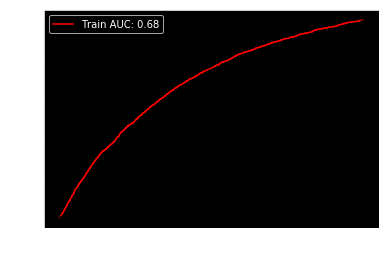

In [382]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
# plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

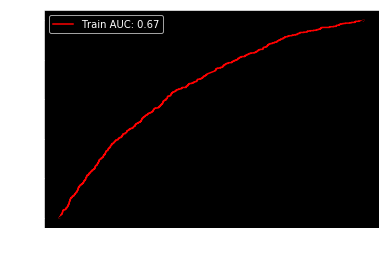

In [383]:
plt.plot(fpr_test, tpr_test,'r-', label = 'Train AUC: %.2f'%auc_test)
# plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# SMOTE balancing

In [387]:
print(X_train_tf.shape)
print(y_train.shape)

(33061, 400)
(33061, 1)


In [281]:
# Using only the features in the feature list for the input
# train_input = X[feature_list]
# train_output = y

# Splitting before SMOTE
# X_train, X_test, Y_train, Y_test = train_test_split(train_input, train_output, test_size=0.20, random_state=0)
print('Original train dataset shape {}'.format(Counter(y_train)))
print('Original test dataset shape {}'.format(Counter(y_train)))


def balancing(X, Y, undersample = None):
    # Oversampling with SMOTE
    smt = SMOTE(random_state=20)
    if undersample:
        smt = SMOTEENN(random_state=20)

    X_new, Y_new = smt.fit_sample(X, Y)
    print('New train dataset shape {}'.format(Counter(Y_new)))
    X_new = pd.DataFrame(X_new, columns = list(X.columns))
    return X_new, Y_new

X_train_balanced, y_train_balanced = balancing(X_train_tf, y_train, undersample=True)

Original train dataset shape Counter({'output_label': 1})
Original test dataset shape Counter({'output_label': 1})


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



New train dataset shape Counter({1: 30338, 0: 11729})


In [283]:
X_train_balanced.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.160539,-0.055232,0.173561,-0.032413,0.097455,-0.086856,0.244244,-0.066422,-0.130823,0.092215,...,-0.157470,-0.116707,-0.119789,0.162902,-0.024979,0.073589,0.036117,0.091771,-0.198869,-0.226303
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.267413,-0.231207,0.232200,-0.454616,0.162566,0.087378,0.138590,0.111590,-0.130123,0.086716,...,-0.066754,-0.206142,0.006833,0.053930,-0.155942,-0.003369,-0.103320,0.126275,0.080613,0.025513
3,-0.063747,-0.059525,0.006568,-0.020993,0.008437,0.081091,0.122322,-0.056495,-0.020067,-0.144269,...,0.067807,0.064796,-0.145615,-0.000049,0.131590,0.053199,-0.033771,0.149826,0.061526,0.001563
4,-0.220060,-0.303640,0.241701,-0.239542,0.037804,-0.073171,0.142256,0.152030,-0.195171,0.174598,...,-0.260003,-0.262536,0.002025,0.023602,-0.287655,0.080420,0.046601,0.020437,-0.132140,0.105816


# Train a decision tree on vectorized notes

In [356]:
# Model building
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def DTCGrid(X_train, X_test, Y_train, Y_test, model):
    if model == 'lr':
        pipeline = Pipeline([('clf',LogisticRegression(penalty = 'l2', random_state = 20000, class_weight="balanced", solver='lbfgs'))])
        param_dist = {'clf__C': [0.0001, 0.0005, 0.001, 0.0033, 0.0066, 0.01, 0.033, 0.066, 0.1, 0.33, 1, 3, 6, 10, 100]}
    
    if model == 'dt':
        pipeline = Pipeline([('clf',DecisionTreeClassifier(criterion='entropy',random_state=20000))])
        # specify parameters and distributions to sample from
        param_dist = {'clf__max_depth': sp_randint(20, 30),
                 'clf__min_samples_split': sp_randint(2, 11)
                    }
    if model == 'rf':
        pipeline = Pipeline([('clf',RandomForestClassifier(criterion='entropy',random_state=20000))])
        # specify parameters and distributions to sample from
        param_dist = {'clf__max_depth': sp_randint(20, 30),
                     'clf__max_features': sp_randint(1, 11),
                 'clf__min_samples_split': sp_randint(2, 11)
                    }
    # run randomized search
    n_iter_search = 20
    rand_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                    n_iter=n_iter_search, cv = 5, n_jobs=-1,verbose=1, scoring='recall')
    rand_search.fit(X_train, Y_train)
    print('Best score: %0.3f' % rand_search.best_score_)
    print('Best parameters set:')
    best_parameters = rand_search.best_estimator_.get_params()
    for param_name in sorted(param_dist.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    predictions = rand_search.predict(X_test)
    print(classification_report(Y_test, predictions))
    print("AUC is {0:.2f}".format(roc_auc_score(Y_test, predictions)))
    print(confusion_matrix(Y_test, predictions))
    return rand_search.best_estimator_

In [357]:
# With SMOTE and Undersampling
best_estimator = DTCGrid(X_train_balanced, X_test_tf, y_train_balanced, y_test, model = 'lr')


Fitting 5 folds for each of 15 candidates, totalling 75 fits


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning:

The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.1min finished


Best score: 0.828
Best parameters set:
	clf__C: 10
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      7716
           1       0.10      0.70      0.18       550

   micro avg       0.58      0.58      0.58      8266
   macro avg       0.53      0.63      0.45      8266
weighted avg       0.91      0.58      0.68      8266

AUC is 0.63
[[4386 3330]
 [ 167  383]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



In [ ]:
best_estimator = DTCGrid(X_train_balanced, X_test_tf, y_train_balanced, y_test, model = 'dt')

In [295]:
X_test_tf.shape
# y_test.shape

(8266, 400)

# Train a logistic regression model

In [374]:
model_lr = LR(C = 0.01, penalty = 'l1', random_state = 3, solver="saga")


print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(model_lr, X_train_balanced, y_train_balanced, cv=5))))
# logreg.fit(X_train, Y_train)


model_lr.fit(X_train_balanced, y_train_balanced)
print("Test Set score: {:.2%}".format(model_lr.score(X_test_tf, y_test)))

Cross Validation Score: 78.09%
Test Set score: 28.66%


In [375]:
y_test_preds = model_lr.predict(X_test_tf)

print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_test_preds)))
print("Precision is {0:.2f}".format(precision_score(y_test, y_test_preds)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_test_preds)))
print("AUC is {0:.2f}".format(roc_auc_score(y_test, y_test_preds)))

print(confusion_matrix(y_test, y_test_preds))

Accuracy is 0.29
Precision is 0.08
Recall is 0.91
AUC is 0.57
[[1870 5846]
 [  51  499]]


In [334]:
# Grid search cv 
from sklearn.model_selection import GridSearchCV

In [371]:
# def get_lr_hyperparams(x, y, nfolds):
#     scoring = {'AUC': 'roc_auc', 
#                'prec': 'precision',
#                'recall': 'recall'}
#     param_grid = {'C': [0.0001, 0.0005, 0.001, 0.0033, 0.0066, 0.01, 0.033, 0.066, 0.1, 0.33, 1, 3, 6, 10, 100]}
#     grid_search = GridSearchCV(LR(penalty='l1', solver='saga', class_weight='balanced', random_state=5, max_iter=100), 
#                                param_grid, scoring=scoring, cv=nfolds, refit='recall')
#     grid_search.fit(x, y)
#     grid_search.best_params_
#     return grid_search.best_params_

In [373]:
# get_lr_hyperparams(X_train_balanced, y_train_balanced, 5)

In [ ]:
#Scale Anrew's data
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('admission_processed.csv', parse_dates = ['admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime', 'next_admittime', 'dob'])

# Defining dictionaries for encoding
admin_type_dict = {'EMERGENCY': 0, 'URGENT': 0, 'ELECTIVE': 1}
gender_dict = {'M': 0, 'F': 1}

# Mapping dictionaries to binary features
df['admission_type'] = df['admission_type'].map(admin_type_dict).astype(int)
df['gender'] = df['gender'].map(gender_dict).astype(int)

feature_set_1 = ['admission_type', 'total_prior_admits','gender', 'age', 'length_of_stay', 'num_medications', 'num_lab_tests',
                'perc_tests_abnormal', 'num_diagnosis']

X = df[feature_set_1]
y = df['output_label']

scaler = MinMaxScaler()
standard_cols = ['total_prior_admits', 'age', 'length_of_stay', 'num_medications', 'num_lab_tests', 'num_diagnosis']

# Normalizing the numeric columns
X[standard_cols] = scaler.fit_transform(X[standard_cols])